# Business case:

Use Case: For this data science challenge you are provided with a dataset containing mobility traces of ~500 taxi cabs in San Francisco collected over ~30 days. The format of each mobility trace file is the following - each line contains [latitude, longitude, occupancy, time], e.g.: [37.75134 -122.39488 0 1213084687], where latitude and longitude are in decimal degrees, occupancy shows if a cab has a fare (1 = occupied, 0 = free) and time is in UNIX epoch format.
The goal of this data science challenge is twofold:
1. To calculate the potential for yearly reduction on CO2 emissions, caused by the taxi cabs roaming without passengers. In your calculation please assume that the taxi cab fleet is changing at the rate of 10% per month (from combustion engine-powered vehicles to electric vehicles). Assume also that the average passenger vehicle emits about 404 grams of CO2 per mile.
2. To build a predictor for taxi drivers, predicting the next place a passenger will hail a cab.

Bonus question:
3. Identify clusters of taxi cabs that you find being relevant

# Methodology

Before applying Data Science techniques, we can make use of various problem solving methodologies and their tools to decompose problems

✓ Lean Six Sigma 

✓ TRIZ (Theory of Inventive Problem Solving) 

✓ CRISP-DM 

✓ Design Thinking

## CRISP-DM

ftp://public.dhe.ibm.com/software/analytics/spss/documentation/modeler/18.0/en/ModelerCRISPDM.pdf

CRISP-DM (CRoss Industry Process for Data Mining) is a process model that describes commonly used approaches that data mining experts use to tackle problems. It is a guide that allows data mining projects to be completed faster with higher quality and less resources. It is an evolutionary and iterative process.

# STEP 1 – BUSINESS UNDERSTANDING 

Firstly an in-depth analysis of the business objectives and needs has to be done. Current situation must be accessed and from these insights, the goals of carrying out the processes must be defined. This should follow the setting up of a plan to proceed. In our case, our aim is finding yearly CO2 emission reduction, predicting for taxi drivers, predicting the next place a passenger will hail a cab and Identify clusters of taxi cabs that you find being relevant.

### Question 1 - CO2 emission reduction

In order to find yearly CO2 emission reduction, we need to find distance via longitude and lattitude in Miles. It should be in miles metric because in the question it is given by average passenger vehicle emits about 404 grams of CO2 per mile. I use only 10% of .txt files. Within those files I keept only occupancy set to zero. Because in the question asked that by the taxi cabs roaming without passengers. 

I calculate the distances of all drivers to have the total distance of interest for one month. I multiply the result by 12 and get the yearly distance of interest for the CO2 emissions
Then, I assume that the taxi cab fleet is changing at the rate of 10% per month. This policy means that the number of taxis with combustion engines is reduced by 10% every month. Accordingly I assume that the distance for CO2 emissions is also reduced by 10% every month. Applying this policy for 12 months gives me the new distance for the CO2 emissions with EVs.

Then, I take the two distances, divide them by 0.1. Because I only took 10% of the files for my calculation and thus approximate the total distance of all taxis. I get the CO2 reduction by multiplying the total distance with the number of CO2 grams per mile and comparing the difference in terms of percentage.



### Question 2 - Next place a passenger will hail a cab (Occupancy Model) - DÜZELTİLECEK

To predict the next place a passenger will hail a cab, I divided the question in to two. First question is what is the next place that cab will go. Second question is predicting a customer hail the cab. 

In the first question, we can think it as time series problem. I build a model that predict the location in t by using as previous location in t-1, t-2 and t-3. First I create simple neural network model with one input layer, one hidden layer and one output layer for one taxi driver. Results are not good therefore I predict longitude and lattitude seperately with Gradient Boosting algorithm. In order to increase performance of GBM model, we can change the previous window and hyper-parameter tuning. Because of time constains I wrote hyper-parameter code but not run it. LSTM could be also very useful for this assignment.

In the second question, I build a Random Forest Classifier to predict whether next location is a pick-up point or not. I subset 10% of the total data and all data and using timestamp data I generate day of week, hour and time data. I think also adding holiday and weather data will be very useful to our model. 

Notes:
I do not do hyper-parameter optimization.
Other algorithms logistic regression, SVM,, XgBoost, etc could have been used.
Getting next pick-up locations
We can get the next pick-up location by combining the trajectory predictor for each taxi driver and the pick-up point classifier.
Using the trajectory predictor, we can predict the coordinates of a taxi driver. These coordinates can be fed into the pick-up point classifier which will indicate the next pick-up location with a certain probability.


### Finding next pick-up point (Final Occupancy Model)

We can get the next pick-up location by combining the next location predictor for each taxi driver and the occupancy classifier.

The next location prediction coordinates can be fed into the pick-up point classifier which will indicate the next pick-up location with a certain probability.

## Bonus Question - Identify clusters of taxi cabs that you find being relevant. 

I apply two different method to identify cluster of taxi cabs.

First is using DBSCAN (Density-Based Spatial Clustering of Applications with Noise) which is a popular unsupervised learning method utilized in model building and machine learning algorithms. I subset 10% of the total data and divided into two in terms of occupancy flag. I looked other cabs where they are driving in the past and where they will go after it. By doing so, I clustered its cabs together based on similarity of behavior.

My second method is implementing RFM methodology in to this question. I subset 10% of the total data and I found total miles per cab, total occupied miles per cab and average active minutes per day. 

# STEP 2 – DATA UNDERSTANDING

We have mobility traces of ~500 taxi cabs in San Francisco collected over ~30 days. The format of each mobility trace file is the following - each line contains [latitude, longitude, occupancy, time] 

In [1]:
import random
import datetime
from os import listdir
from os.path import join as jp

import numpy as np
import pandas as pd
from pandas import DataFrame
from pandas import Series
import matplotlib.pyplot as plt
from math import radians, degrees, sin, cos, asin, acos, sqrt
import tensorflow

from keras.models import Sequential
from keras.layers import Dense, Input, Activation, BatchNormalization, Dropout

from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

pd.options.mode.chained_assignment = None

Using TensorFlow backend.


In [2]:
import os 
os.getcwd()

'/Users/mustafaozturk'

In [3]:
path = '/Users/mustafaozturk/Desktop/cases/PMI Case 2/cabspottingdata'

all_files = [file_name for file_name in listdir(path) if file_name.endswith('.txt')]
print(f'All files are {len(all_files)}')

PerofFiles = 0.1

random.Random(1923).shuffle(all_files)
SelectedFiles = all_files[:int(PerofFiles * len(all_files))]

print(f'\n{len(SelectedFiles)} randomly selected files')

All files are 537

53 randomly selected files


# STEP 3 – DATA PREPERATION

Most data used for data mining was originally collected and preserved for other purposes and needs some refinement before it is ready to use for modeling.

The data preparation phase includes five tasks. These are

Selecting data

Cleaning data

Constructing data

Integrating data

Formatting data

In [4]:
def ConverttoDF(file_name: str):
    df = pd.read_csv(jp(path, file_name), sep=' ', header=None)
    df.index = file_name.split('.')[0] + "_" + df.index.map(str)
    df.columns = ['Lattitude', 'Longitude', 'Occupancy', 'Timestamp']
    df['Taxi'] = file_name.split('.')[0]
    return df

def PreviousCoordinates(df: DataFrame):
    df['PrevLattitude'] = df.shift(1)['Lattitude']
    df['PrevLongitude'] = df.shift(1)['Longitude']
    df = df.dropna()
    return df

def EstimatedDistance(row: Series):
    # formulation of finding distance via longitude and lattitude in Miles from
    # https://gist.github.com/rochacbruno/2883505#gistcomment-1394026
    Longitude = row['Longitude']
    Lattitude = row['Lattitude']
    PrevLongitude = row['PrevLongitude']
    PrevLattitude = row['PrevLattitude']
    Longitude, Lattitude, PrevLongitude, PrevLattitude = map(radians, 
                                                                    [Longitude, Lattitude, 
                                                                    PrevLongitude, PrevLattitude])
    try:
        return 3959 * (acos(sin(Lattitude) * sin(PrevLattitude) + cos(Lattitude) * cos(PrevLattitude) * 
                                cos(Longitude - PrevLongitude)))
    except:
        return 0.0

def DistanceCalculation(df: DataFrame):
    df['Miles'] = 0.0
    df['Miles'] = df.apply(lambda row: EstimatedDistance(row), axis=1)
    return df

Data = pd.DataFrame()
for f in SelectedFiles:
    df = ConverttoDF(file_name=f)
    df = PreviousCoordinates(df=df)
    df = DistanceCalculation(df=df)
    Data = pd.concat([Data, df])

In [5]:
Data.head()

,Lattitude,Longitude,Occupancy,Timestamp,Taxi,PrevLattitude,PrevLongitude,Miles
new_ajsnedsi_1,37.75124,-122.39527,0,1211022396,new_ajsnedsi,37.75167,-122.39460,0.047145
new_ajsnedsi_2,37.75027,-122.39532,0,1211022456,new_ajsnedsi,37.75124,-122.39527,0.067080
new_ajsnedsi_3,37.75224,-122.39650,0,1211022516,new_ajsnedsi,37.75027,-122.39532,0.150617
new_ajsnedsi_4,37.75281,-122.39083,0,1211022577,new_ajsnedsi,37.75224,-122.39650,0.312262
new_ajsnedsi_5,37.76503,-122.39311,0,1211022637,new_ajsnedsi,37.75281,-122.39083,0.853509


In [6]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
Data.describe()

,Lattitude,Longitude,Occupancy,Timestamp,PrevLattitude,PrevLongitude,Miles
count,1079188.00,1079188.00,1079188.00,1079188.00,1079188.00,1079188.00,1079188.00
mean,37.76,-122.41,0.45,1212048057.47,37.76,-122.41,0.33
std,0.05,0.03,0.50,588164.74,0.05,0.03,1.47
min,35.92,-122.61,0.00,1211018413.00,35.92,-122.61,0.00
25%,37.76,-122.43,0.00,1211547971.00,37.76,-122.43,0.03
50%,37.78,-122.41,0.00,1212050459.50,37.78,-122.41,0.15
75%,37.79,-122.40,1.00,1212564613.25,37.79,-122.40,0.31
max,50.31,-122.00,1.00,1213088997.00,50.31,-122.00,867.64


In [7]:
NoPassanger = Data[Data['Occupancy'] == 0]
#Distance Without Passanger
DistanceWOPassanger = NoPassanger.groupby(by=['Taxi'])['Miles'].sum()
print(DistanceWOPassanger)

Taxi
new_abmuyawm    2107.93
new_acvebr      3865.09
new_afweka      2363.08
new_ajsnedsi    3065.84
new_amknywr     2059.95
new_ancedvab     779.90
new_andyol      2324.05
new_aniajcr     2299.33
new_anupwr      1808.28
new_artgagvu    2264.14
new_asigno      2801.32
new_atidfi      2697.00
new_easnsvu     2724.33
new_ecdiwovu    2639.48
new_eglohabs    2327.33
new_eicmynts    1541.58
new_ejcrur      2129.92
new_elswcky     2373.92
new_eoffrij     2407.09
new_eybyay      3067.37
new_icedpa      1329.37
new_ictlypt     1943.14
new_idjoat       350.20
new_idjojwa      432.45
new_idodly      2453.26
new_igglitby    3141.53
new_ikujfurk    2029.61
new_imhacy       488.72
new_indtwrat    2752.54
new_iofplik     2756.06
new_iovhar      2590.61
new_ipdraw       406.54
new_mfeuer        16.90
new_oasthul     1855.25
new_obsimjio    2097.10
new_ocwyit      1763.95
new_ogikligu    2210.60
new_ojvighta    2769.50
new_oksbosfl    2288.03
new_omdrid       703.10
new_omluaj      2906.39
new_ononma 

# STEP 4 – MODELLING

After data preparation, our data is already in good shape, and now you can search for useful patterns in your data.
The modeling phase includes four tasks. These are

Selecting modeling techniques

Designing test(s)

Building model(s)

Assessing model(s)

## Question 1: CO2 Reduction Analysis

In [8]:
DistanceWOPassangerPerMonth = DistanceWOPassanger.sum()
#We can assume that multiplying monthly distance by 12, we can find the yearly distance.
DistanceWOPassangerPerYear = DistanceWOPassangerPerMonth * 12

print(f'The distance for CO2 in one year (combustion engine-powered vehicles) '
      f'is approx {round(DistanceWOPassangerPerYear)} Miles\n')


#electric vehicles
DistanceWOPassangerPerYearEV = 0.0


#assume that the taxi cab fleet is changing at the rate of 10% per month
for month in range(12):
    if month == 0:
        DistanceWOPassangerPerMonthEV = DistanceWOPassangerPerMonth
        DistanceWOPassangerPerYearEV = DistanceWOPassangerPerMonth
    else:
        DistanceWOPassangerPerMonthEV = DistanceWOPassangerPerMonthEV * 0.9
        DistanceWOPassangerPerYearEV += DistanceWOPassangerPerMonthEV
    print(f'The distance for CO2 after {month} month(s) of'
          f' Electric Vehicles is approx {round(DistanceWOPassangerPerMonthEV, 3)} Miles')
    
print(f'\nThe distance for CO2 after one year of Electric Vehicles '
      f' is approx {round(DistanceWOPassangerPerYearEV)} Miles')

The distance for CO2 in one year (combustion engine-powered vehicles) is approx 1967185.0 Miles

The distance for CO2 after 0 month(s) of Electric Vehicles is approx 163932.056 Miles
The distance for CO2 after 1 month(s) of Electric Vehicles is approx 147538.85 Miles
The distance for CO2 after 2 month(s) of Electric Vehicles is approx 132784.965 Miles
The distance for CO2 after 3 month(s) of Electric Vehicles is approx 119506.469 Miles
The distance for CO2 after 4 month(s) of Electric Vehicles is approx 107555.822 Miles
The distance for CO2 after 5 month(s) of Electric Vehicles is approx 96800.24 Miles
The distance for CO2 after 6 month(s) of Electric Vehicles is approx 87120.216 Miles
The distance for CO2 after 7 month(s) of Electric Vehicles is approx 78408.194 Miles
The distance for CO2 after 8 month(s) of Electric Vehicles is approx 70567.375 Miles
The distance for CO2 after 9 month(s) of Electric Vehicles is approx 63510.637 Miles
The distance for CO2 after 10 month(s) of Electric

In [9]:
CO2GramsPerMiles = 404

#CO2 emissions without electronic vehicles

CO2EmissionWOEV = DistanceWOPassangerPerYear / PerofFiles * CO2GramsPerMiles

#CO2 emissions with electronic vehicles

CO2EmissionWEV = DistanceWOPassangerPerYearEV / PerofFiles * CO2GramsPerMiles

CO2Reduction = round((CO2EmissionWOEV - CO2EmissionWEV) / CO2EmissionWOEV, 4)

print(f'The CO2 emissions are reduced by {CO2Reduction * 100} %')

The CO2 emissions are reduced by 40.2 %


## Question 2. To build a predictor for taxi drivers, predicting the next place a passenger will hail a cab.

In [10]:
lat_offset = 37.0
long_offset = -122.0
taxi_driver = SelectedFiles[0]

datapoints = []
with open(file=jp(path, taxi_driver), mode='r') as f:
    for line in f:
        lat, long, occ, ts = line.split()
        datapoints.append([float(lat) - lat_offset, float(long) - long_offset])

In [11]:
TaxiDrivers = SelectedFiles[0]

Data = []
with open(file=jp(path, TaxiDrivers), mode='r') as f:
     for line in f:
        Lattitute, Longitute, Occupation, TS = line.split()
        Data.append([Lattitute, Longitute])


In [12]:
X = []
Y = []
timeseries = 3
for x in range(len(Data) - timeseries):
    TimeSteps = Data[x:x + timeseries]
    X.append([TS for TimeStep in TimeSteps for TS in TimeStep])
    Y.append(Data[x + timeseries])


In [13]:
TraingTestSize = round(len(X) * 0.8)

X_train = np.array(X[:TraingTestSize])
X_test = np.array(X[TraingTestSize:])

Y_train = np.array(Y[:TraingTestSize])
Y_test = np.array(Y[TraingTestSize:])

In [14]:
model = Sequential()
model.add(BatchNormalization())
model.add(Dense(4, input_shape=(6,)))
model.add(Activation('tanh'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(2))
model.add(Activation('linear'))
model.compile(loss='mean_squared_error', optimizer='Adam')

In [15]:
history = model.fit(X_train, Y_train, epochs=50, validation_data=(X_test, Y_test), verbose=1)
print(f'MSE on training set {history.history["loss"][-1]}')
print(f'MSE on testing set {history.history["val_loss"][-1]}')

Train on 18555 samples, validate on 4639 samples
Epoch 1/50
18555/18555 [==============================] - 2s 99us/step - loss: 7957.0395 - val_loss: 7514.4366
Epoch 2/50
18555/18555 [==============================] - 1s 71us/step - loss: 6858.2721 - val_loss: 6083.7403
Epoch 3/50
18555/18555 [==============================] - 1s 72us/step - loss: 5226.2959 - val_loss: 4362.7863
Epoch 4/50
18555/18555 [==============================] - 1s 73us/step - loss: 3560.9336 - val_loss: 2808.3113
Epoch 5/50
18555/18555 [==============================] - 1s 70us/step - loss: 2182.4853 - val_loss: 1617.8880
Epoch 6/50
18555/18555 [==============================] - 1s 71us/step - loss: 1174.6230 - val_loss: 786.5240
Epoch 7/50
18555/18555 [==============================] - 1s 72us/step - loss: 512.0293 - val_loss: 290.1507
Epoch 8/50
18555/18555 [==============================] - 1s 71us/step - loss: 162.5245 - val_loss: 71.5828
Epoch 9/50
18555/18555 [==============================] - 1s 71us/ste

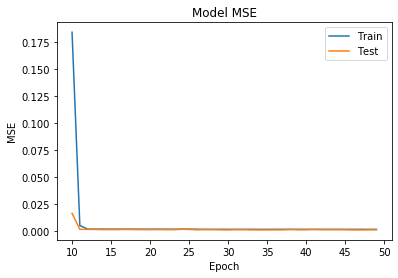

In [16]:
_, ax = plt.subplots()
ax.plot(history.history['loss'][10:])
ax.plot(history.history['val_loss'][10:])
plt.title('Model MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
ax.set_xticklabels(np.arange(5, 55, 5))
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [17]:
Y_pred = model.predict(X_test)

# STEP 5 – EVALUATION (NN Model)

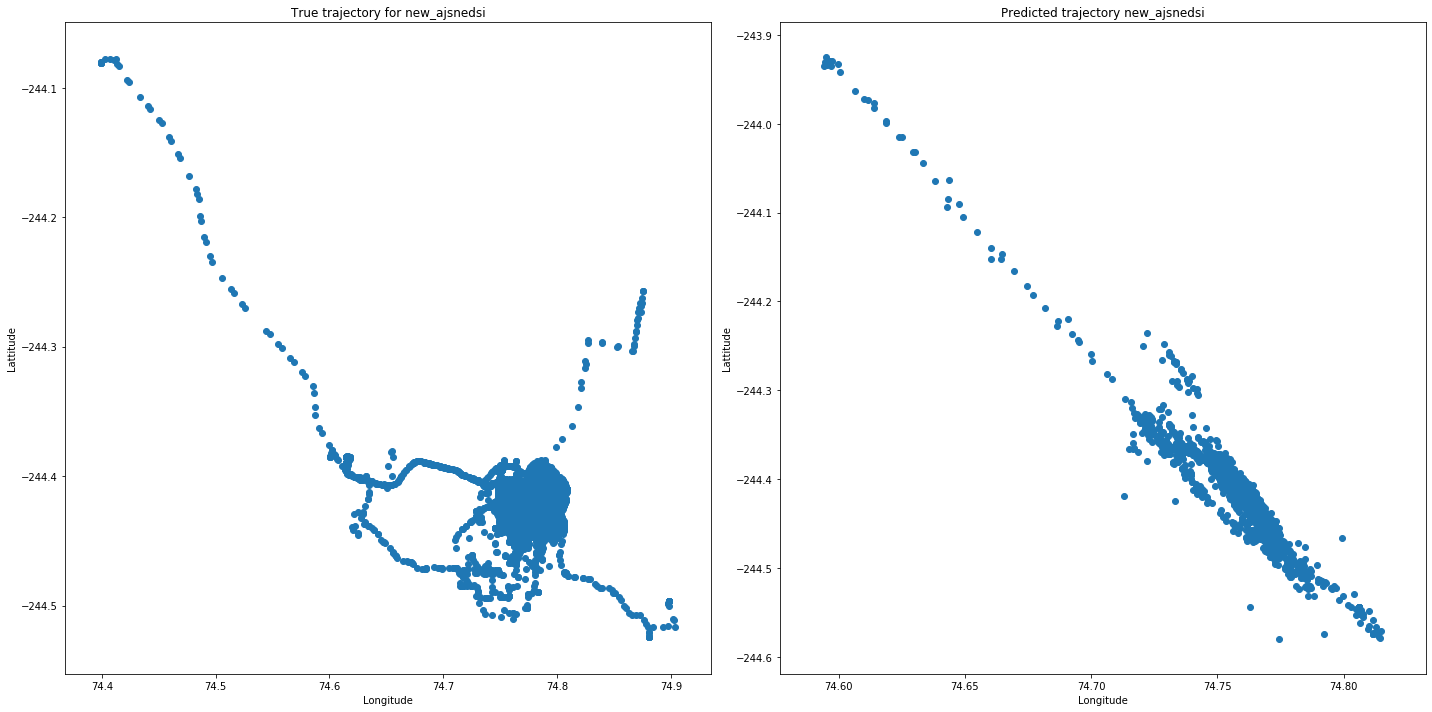

In [18]:
plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.scatter(pd.to_numeric(Y_test[:,0]) + lat_offset, pd.to_numeric(Y_test[:,-1]) + long_offset)
plt.title('True trajectory for {}'.format(taxi_driver.split('.')[0]))
plt.ylabel('Lattitude')
plt.xlabel('Longitude')
plt.subplot(122)
plt.scatter(pd.to_numeric(Y_pred[:,0]) + lat_offset, pd.to_numeric(Y_pred[:,-1]) + long_offset)
plt.title('Predicted trajectory {}'.format(taxi_driver.split('.')[0]))
plt.ylabel('Lattitude')
plt.xlabel('Longitude')
plt.tight_layout()

## Second Model for predicting next place (GBM)

### Calculating Lattitude 

In [19]:
TaxiDrivers = SelectedFiles[0]

DataLat = []
with open(file=jp(path, TaxiDrivers), mode='r') as f:
     for line in f:
        Lattitute, Longitute, Occupation, TS = line.split()
        DataLat.append([Lattitute])


In [20]:
XLat = []
YLat = []
timeseries = 3
for x in range(len(DataLat) - timeseries):
    TimeSteps = DataLat[x:x + timeseries]
    XLat.append([TS for TimeStep in TimeSteps for TS in TimeStep])
    YLat.append(DataLat[x + timeseries])

In [21]:
TraingTestSize = round(len(X) * 0.8)

XLat_train = np.array(XLat[:TraingTestSize])
XLat_test = np.array(XLat[TraingTestSize:])

YLat_train = np.array(YLat[:TraingTestSize])
YLat_test = np.array(YLat[TraingTestSize:])

import numpy as np
XLat_train=XLat_train.astype(np.float)
XLat_test=XLat_test.astype(np.float)
YLat_train=YLat_train.astype(np.float)
YLat_test=YLat_test.astype(np.float)

In [22]:
from sklearn.ensemble import GradientBoostingRegressor 
gbmregressor=GradientBoostingRegressor(n_estimators=100) 
model_gbm_Lat=gbmregressor.fit(XLat_train, YLat_train) 
pred_gbm_Lat=model_gbm_Lat.predict(XLat_test) 
pred_gbm_Lat

/Users/mustafaozturk/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([37.79872136, 37.80018943, 37.80261972, ..., 37.71015898,
       37.69753669, 37.67938896])

### Lattitude Model Evaluation

In [23]:
YLat_test_2=YLat_test.reshape(-1)

In [24]:
actual_Lat=pd.Series(YLat_test_2)
pred_Lat=pd.Series(pred_gbm_Lat).reset_index()
result_Lat=pd.concat([actual_Lat,pred_Lat],axis=1)

In [25]:
result_Lat.set_index("index",inplace=True)
result_Lat.index.name=None
result_Lat.columns = ['actual_Lat', 'pred_Lat']
result_Lat

,actual_Lat,pred_Lat
0,37.80,37.80
1,37.80,37.80
2,37.80,37.80
3,37.80,37.80
4,37.80,37.80
...,...,...
4634,37.73,37.74
4635,37.72,37.73
4636,37.70,37.71
4637,37.69,37.70


In [26]:
error=result_Lat.actual_Lat-result_Lat.pred_Lat

R2=np.corrcoef(result_Lat.actual_Lat,result_Lat.pred_Lat)
MSE=(error**2).mean()
RMSE=(np.sqrt(MSE)).mean()
MAE=(np.abs(error)).mean()
MAPE=(np.abs(error)/result_Lat.actual_Lat).mean()

In [27]:
R2,MSE,RMSE,MAE,MAPE

(array([[1.       , 0.9945679],
        [0.9945679, 1.       ]]),
 3.2253662166237245e-05,
 0.005679230772405472,
 0.0025033588973939545,
 6.634112146550933e-05)

## Calculating Longitude

In [28]:
TaxiDrivers = SelectedFiles[0]

DataLon = []
with open(file=jp(path, TaxiDrivers), mode='r') as f:
     for line in f:
        Lattitute, Longitute, Occupation, TS = line.split()
        DataLon.append([Longitute])

In [29]:
XLon = []
YLon = []
timeseries = 3
for x in range(len(DataLon) - timeseries):
    TimeSteps = DataLon[x:x + timeseries]
    XLon.append([TS for TimeStep in TimeSteps for TS in TimeStep])
    YLon.append(DataLon[x + timeseries])

In [30]:
TraingTestSize = round(len(X) * 0.8)

XLon_train = np.array(XLon[:TraingTestSize])
XLon_test = np.array(XLon[TraingTestSize:])

YLon_train = np.array(YLon[:TraingTestSize])
YLon_test = np.array(YLon[TraingTestSize:])

import numpy as np
XLon_train=XLon_train.astype(np.float)
XLon_test=XLon_test.astype(np.float)
YLon_train=YLon_train.astype(np.float)
YLon_test=YLon_test.astype(np.float)

In [31]:
from sklearn.ensemble import GradientBoostingRegressor 
gbmregressor=GradientBoostingRegressor(n_estimators=100) 
model_gbm_Lon=gbmregressor.fit(XLon_train, YLon_train) 
pred_gbm_Lon=model_gbm_Lon.predict(XLon_test) 
pred_gbm_Lon

/Users/mustafaozturk/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([-122.40976308, -122.41442735, -122.41703373, ..., -122.39755676,
       -122.39394557, -122.39130202])

### Longitude Model Evaluations

In [32]:
YLon_test_2=YLon_test.reshape(-1)

In [33]:
actual_Lon=pd.Series(YLon_test_2)
pred_Lon=pd.Series(pred_gbm_Lon).reset_index()
result_Lon=pd.concat([actual_Lon,pred_Lon],axis=1)

In [34]:
result_Lon.set_index("index",inplace=True)
result_Lon.index.name=None
result_Lon.columns = ['actual_Lon', 'pred_Lon']
result_Lon

,actual_Lon,pred_Lon
0,-122.41,-122.41
1,-122.42,-122.41
2,-122.42,-122.42
3,-122.43,-122.42
4,-122.43,-122.43
...,...,...
4634,-122.40,-122.41
4635,-122.40,-122.40
4636,-122.39,-122.40
4637,-122.39,-122.39


In [35]:
error=result_Lon.actual_Lon-result_Lon.pred_Lon

R2=np.corrcoef(result_Lon.actual_Lon,result_Lon.pred_Lon)
MSE=(error**2).mean()
RMSE=(np.sqrt(MSE)).mean()
MAE=(np.abs(error)).mean()
MAPE=(np.abs(error)/result_Lon.actual_Lon).mean()

In [36]:
R2,MSE,RMSE,MAE,MAPE

(array([[1.        , 0.99248058],
        [0.99248058, 1.        ]]),
 2.0515489793177722e-05,
 0.004529402807565002,
 0.002600579939125634,
 -2.1244683505761435e-05)

In [37]:
Y_test_Final = np.concatenate([YLat_test, YLon_test], axis=1)

In [38]:
Pred_Final = np.concatenate([pred_gbm_Lat.reshape(-1,1), pred_gbm_Lon.reshape(-1,1)], axis=1)

# STEP 5 – EVALUATION (GBM Model)

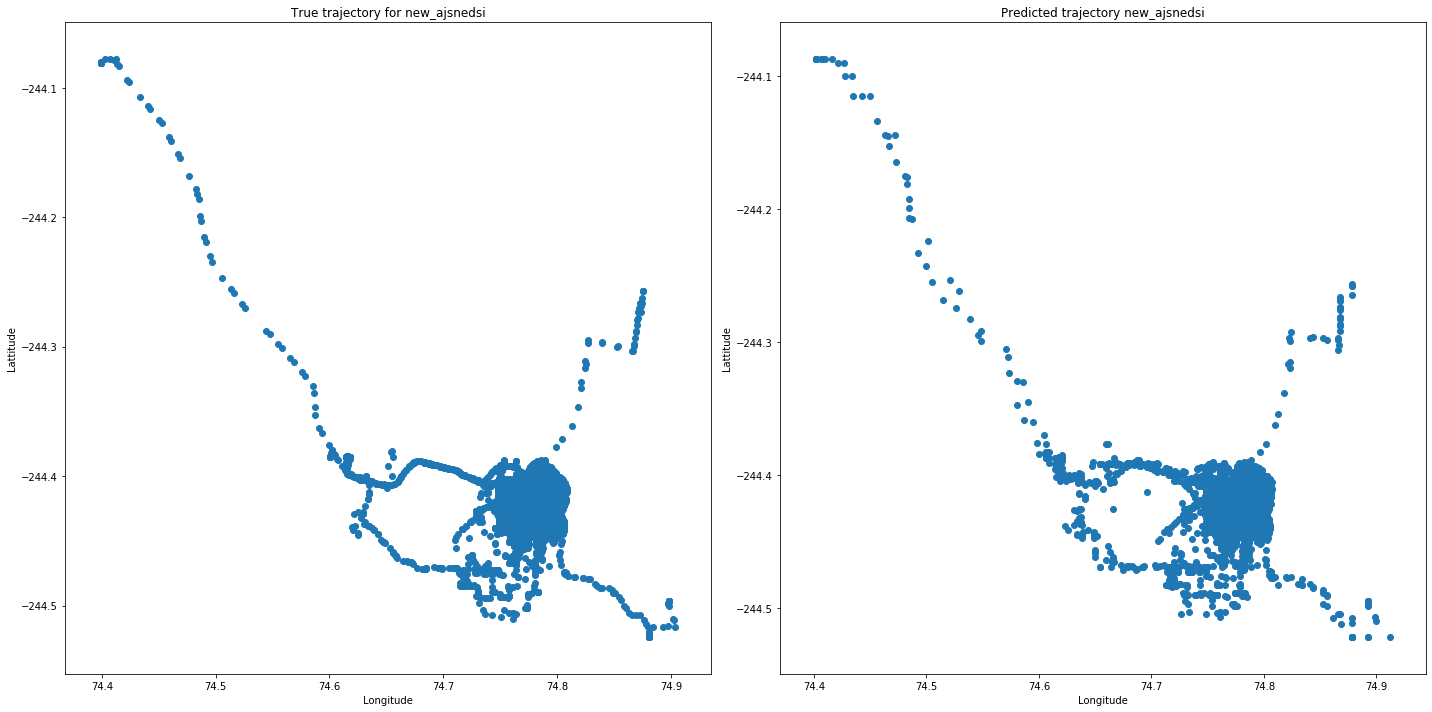

In [39]:
plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.scatter(pd.to_numeric(Y_test_Final[:,0]) + lat_offset, pd.to_numeric(Y_test_Final[:,-1]) + long_offset)
#plt.scatter(Y_test[:,0] + lat_offset, Y_test[:,-1] + long_offset)
plt.title('True trajectory for {}'.format(taxi_driver.split('.')[0]))
plt.ylabel('Lattitude')
plt.xlabel('Longitude')
plt.subplot(122)
#plt.scatter(pd.to_numeric(pred_gbm_Lat[:,0]) + lat_offset, pd.to_numeric(pred_gbm_Lat[:,-1]) + long_offset)
plt.scatter(Pred_Final[:,0] + lat_offset, Pred_Final[:,-1] + long_offset)
plt.title('Predicted trajectory {}'.format(taxi_driver.split('.')[0]))
plt.ylabel('Lattitude')
plt.xlabel('Longitude')
plt.tight_layout()

### Hyperparameter Tuning

#### Longitude hyperparameter

# STEP 4 – MODELLING

## Modelling Occupancy

In [78]:
import datetime

def DateExtraction(row: Series):
    dt = datetime.datetime.fromtimestamp(row['Timestamp'])
    row['day'] = dt.weekday()
    row['hour'] = dt.hour
    row['minute'] = dt.minute
    row['monthday'] = dt.day
    return row

In [79]:
data = pd.DataFrame()
for f in SelectedFiles:
    df = ConverttoDF(file_name=f)
    df = PreviousCoordinates(df=df)
    df = DistanceCalculation(df=df)
    data = pd.concat([data, df])

In [80]:
data = data[['Lattitude', 'Longitude', 'Occupancy', 'Timestamp']]
data['day'] = 0
data['hour'] = 0
data['minute'] = 0
data['monthday'] = 0
data = data.apply(lambda row: DateExtraction(row), axis=1)
data.head()

,Lattitude,Longitude,Occupancy,Timestamp,day,hour,minute,monthday
new_ajsnedsi_1,37.75,-122.40,0.00,1211022396.00,5.00,14.00,6.00,17.00
new_ajsnedsi_2,37.75,-122.40,0.00,1211022456.00,5.00,14.00,7.00,17.00
new_ajsnedsi_3,37.75,-122.40,0.00,1211022516.00,5.00,14.00,8.00,17.00
new_ajsnedsi_4,37.75,-122.39,0.00,1211022577.00,5.00,14.00,9.00,17.00
new_ajsnedsi_5,37.77,-122.39,0.00,1211022637.00,5.00,14.00,10.00,17.00


In [81]:
X = data.drop(labels=['Occupancy', 'Timestamp'], axis=1)
X['Lattitude'] = X['Lattitude'] - lat_offset
X['Longitude'] = X['Longitude'] - long_offset

Y = data['Occupancy']

In [82]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify=Y, test_size=0.2, random_state=0)

In [83]:
baseline_acc = round(Y_test[Y_test == 0].shape[0] / Y_test.shape[0], 3)
print(f'The baseline accuracy of a naive model is {baseline_acc}')

The baseline accuracy of a naive model is 0.549


In [84]:
clf = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=0)
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
acc = round(accuracy_score(Y_test, Y_pred), 3)
print(f'The accuracy is {acc}')

The accuracy is 0.713


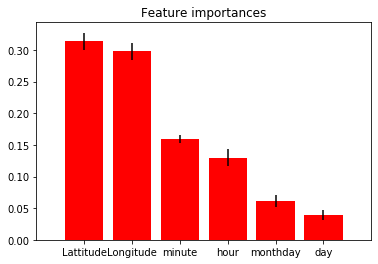

In [85]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), [X_train.columns.tolist()[idx]  for idx in indices])
plt.xlim([-1, X_train.shape[1]])
plt.show()

### Adding new variable - WeatherData

In [86]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2008-04-01', end='2008-08-31').to_pydatetime()
print(holidays)

[datetime.datetime(2008, 5, 26, 0, 0) datetime.datetime(2008, 7, 4, 0, 0)]


In [88]:
 
# to explicitly use the lambda function for the same effect as above

data_new = data
data_new['Holiday_Flag'] = [(lambda x: (x in holidays) * 1)(x) for x in data_new['Timestamp']]


In [89]:
print(data_new)

                  Lattitude  Longitude  Occupancy     Timestamp  day  hour  \
new_ajsnedsi_1        37.75    -122.40       0.00 1211022396.00 5.00 14.00   
new_ajsnedsi_2        37.75    -122.40       0.00 1211022456.00 5.00 14.00   
new_ajsnedsi_3        37.75    -122.40       0.00 1211022516.00 5.00 14.00   
new_ajsnedsi_4        37.75    -122.39       0.00 1211022577.00 5.00 14.00   
new_ajsnedsi_5        37.77    -122.39       0.00 1211022637.00 5.00 14.00   
...                     ...        ...        ...           ...  ...   ...   
new_idjojwa_4991      37.75    -122.39       0.00 1213088788.00 1.00 12.00   
new_idjojwa_4992      37.75    -122.39       0.00 1213088817.00 1.00 12.00   
new_idjojwa_4993      37.75    -122.39       0.00 1213088877.00 1.00 12.00   
new_idjojwa_4994      37.75    -122.39       0.00 1213088937.00 1.00 12.00   
new_idjojwa_4995      37.75    -122.39       0.00 1213088997.00 1.00 12.00   

                  minute  monthday  Holiday_Flag  
new_ajsnedsi

In [90]:
X_new = data.drop(labels=['Occupancy', 'Timestamp'], axis=1)
X_new['Lattitude'] = X_new['Lattitude'] - lat_offset
X_new['Longitude'] = X_new['Longitude'] - long_offset

Y_new = data_new['Occupancy']

In [91]:
X_new_train, X_new_test, Y_new_train, Y_new_test = train_test_split(X_new, Y_new, stratify=Y, test_size=0.2, random_state=0)

In [92]:
baseline_acc_new = round(Y_new_test[Y_new_test == 0].shape[0] / Y_new_test.shape[0], 3)
print(f'The baseline accuracy of a naive model is {baseline_acc_new}')

The baseline accuracy of a naive model is 0.549


In [93]:
clf_new = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=0)
clf_new.fit(X_new_train, Y_new_train)
Y_pred_new = clf_new.predict(X_new_test)
acc_new = round(accuracy_score(Y_new_test, Y_pred_new), 3)
print(f'The accuracy is {acc_new}')

The accuracy is 0.715


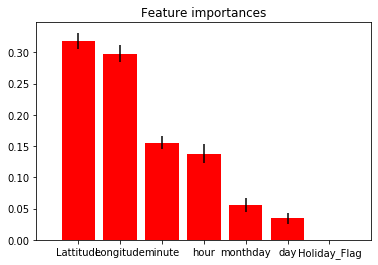

In [94]:
importances = clf_new.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_new.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_new.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_new_train.shape[1]), [X_new_train.columns.tolist()[idx]  for idx in indices])
plt.xlim([-1, X_new_train.shape[1]])
plt.show()

### Model Comparisons 

In [100]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
 
results = confusion_matrix(Y_test, Y_pred)
print ('Confusion Matrix :')
print(results) 
print ('Accuracy Score :',accuracy_score(Y_test, Y_pred) )
print ('Report : ')
print (classification_report(Y_test, Y_pred) )

Confusion Matrix :
[[84677 33834]
 [28152 69175]]
Accuracy Score : 0.7128123870680788
Report : 
              precision    recall  f1-score   support

         0.0       0.75      0.71      0.73    118511
         1.0       0.67      0.71      0.69     97327

    accuracy                           0.71    215838
   macro avg       0.71      0.71      0.71    215838
weighted avg       0.71      0.71      0.71    215838



In [102]:
results_new = confusion_matrix(Y_new_test, Y_pred_new) 
print ('Confusion Matrix :')
print(results_new) 
print ('Accuracy Score :',accuracy_score(Y_new_test, Y_pred_new) )
print ('Report : ')
print (classification_report(Y_new_test, Y_pred_new) )

Confusion Matrix :
[[85320 33191]
 [28347 68980]]
Accuracy Score : 0.7148880178652508
Report : 
              precision    recall  f1-score   support

         0.0       0.75      0.72      0.73    118511
         1.0       0.68      0.71      0.69     97327

    accuracy                           0.71    215838
   macro avg       0.71      0.71      0.71    215838
weighted avg       0.72      0.71      0.72    215838



# Bonus Question

In [57]:
def visualize_dbscan(db: DBSCAN, X: DataFrame):

    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True

    labels = db.labels_
    
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print('Estimated number of clusters: %d' % n_clusters_)

    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]
            continue

        class_member_mask = (labels == k)

        xy = X[class_member_mask & core_samples_mask].values
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=14)

        xy = X[class_member_mask & ~core_samples_mask].values
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)

    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.show()

Estimated number of clusters: 207


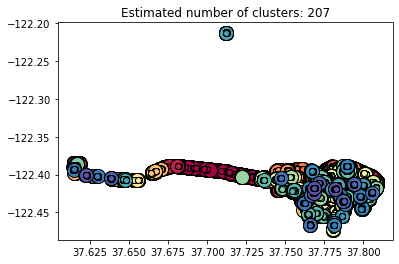

In [58]:
sampled_data = data[data['Occupancy'] == 1][['Lattitude', 'Longitude']].sample(frac=0.3, random_state=0)

db = DBSCAN(eps=0.0005, min_samples=50)
db.fit(sampled_data)
visualize_dbscan(db=db, X=sampled_data)

Estimated number of clusters: 234


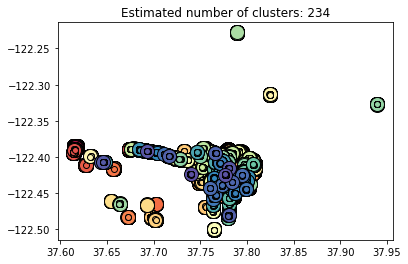

In [59]:
sampled_data = data[data['Occupancy'] == 0][['Lattitude', 'Longitude']].sample(frac=0.3, random_state=0)

db = DBSCAN(eps=0.0005, min_samples=50)
db.fit(sampled_data)
visualize_dbscan(db=db, X=sampled_data)

### Businesswise Segmentation (RFM Segmentation)

In [60]:
import datetime

def DateExtraction(row: Series):
    dt = datetime.datetime.fromtimestamp(row['Timestamp'])
    row['day'] = dt.weekday()
    row['hour'] = dt.hour
    row['minute'] = dt.minute
    row['monthday'] = dt.day
    return row

In [61]:
data = pd.DataFrame()
for f in SelectedFiles:
    df = ConverttoDF(file_name=f)
    df = PreviousCoordinates(df=df)
    df = DistanceCalculation(df=df)
    data = pd.concat([data, df])
data = data[['Lattitude', 'Longitude', 'Occupancy', 'Taxi','Timestamp']]
data['day'] = 0
data['hour'] = 0
data['minute'] = 0
data['monthday'] = 0
data = data.apply(lambda row: DateExtraction(row), axis=1)
data.head()

,Lattitude,Longitude,Occupancy,Taxi,Timestamp,day,hour,minute,monthday
new_ajsnedsi_1,37.75,-122.40,0,new_ajsnedsi,1211022396,5,14,6,17
new_ajsnedsi_2,37.75,-122.40,0,new_ajsnedsi,1211022456,5,14,7,17
new_ajsnedsi_3,37.75,-122.40,0,new_ajsnedsi,1211022516,5,14,8,17
new_ajsnedsi_4,37.75,-122.39,0,new_ajsnedsi,1211022577,5,14,9,17
new_ajsnedsi_5,37.77,-122.39,0,new_ajsnedsi,1211022637,5,14,10,17


In [62]:
Segment = pd.DataFrame()
for f in SelectedFiles:
    df = ConverttoDF(file_name=f)
    df = PreviousCoordinates(df=df)
    df = DistanceCalculation(df=df)
    Segment = pd.concat([Segment, df])
    



In [63]:
MileCover=pd.DataFrame()

MileCover = Segment.groupby(by=['Taxi'])['Miles'].sum()

print(MileCover)

Taxi
new_abmuyawm     4945.10
new_acvebr       6668.34
new_afweka       5431.69
new_ajsnedsi     6603.38
new_amknywr      5606.30
new_ancedvab     1822.48
new_andyol       5451.43
new_aniajcr      5326.07
new_anupwr       4006.42
new_artgagvu     5339.73
new_asigno       6106.54
new_atidfi       6433.05
new_easnsvu      5812.89
new_ecdiwovu     6169.27
new_eglohabs     5371.02
new_eicmynts     3423.72
new_ejcrur       4703.90
new_elswcky      5734.05
new_eoffrij      5696.08
new_eybyay       6651.21
new_icedpa       3027.34
new_ictlypt      4708.31
new_idjoat        771.99
new_idjojwa      1122.90
new_idodly       6323.11
new_igglitby     6704.11
new_ikujfurk     4579.91
new_imhacy       1147.65
new_indtwrat     6153.95
new_iofplik      5985.70
new_iovhar       5933.90
new_ipdraw        744.10
new_mfeuer         25.98
new_oasthul      4449.06
new_obsimjio     5222.93
new_ocwyit       4164.55
new_ogikligu     5011.57
new_ojvighta     6126.91
new_oksbosfl     5938.80
new_omdrid       182

In [64]:
WPassangerDistance = Segment[Segment['Occupancy'] == 1]
#Distance Without Passanger
DistanceWPassanger=pd.DataFrame()
DistanceWPassanger = WPassangerDistance.groupby(by=['Taxi'])['Miles'].sum()

In [65]:
RFMData = pd.merge(MileCover,DistanceWPassanger, on='Taxi', how='left')
print(RFMData)

               Miles_x  Miles_y
Taxi                           
new_abmuyawm   4945.10  2837.17
new_acvebr     6668.34  2803.25
new_afweka     5431.69  3068.61
new_ajsnedsi   6603.38  3537.55
new_amknywr    5606.30  3546.35
new_ancedvab   1822.48  1042.58
new_andyol     5451.43  3127.38
new_aniajcr    5326.07  3026.74
new_anupwr     4006.42  2198.14
new_artgagvu   5339.73  3075.60
new_asigno     6106.54  3305.22
new_atidfi     6433.05  3736.04
new_easnsvu    5812.89  3088.56
new_ecdiwovu   6169.27  3529.79
new_eglohabs   5371.02  3043.68
new_eicmynts   3423.72  1882.14
new_ejcrur     4703.90  2573.98
new_elswcky    5734.05  3360.13
new_eoffrij    5696.08  3288.99
new_eybyay     6651.21  3583.84
new_icedpa     3027.34  1697.96
new_ictlypt    4708.31  2765.17
new_idjoat      771.99   421.79
new_idjojwa    1122.90   690.45
new_idodly     6323.11  3869.85
new_igglitby   6704.11  3562.57
new_ikujfurk   4579.91  2550.30
new_imhacy     1147.65   658.93
new_indtwrat   6153.95  3401.41
new_iofp

In [66]:

output  = pd.DataFrame()
output = data[['Taxi','monthday']]
output = output.drop_duplicates()
ActDay = pd.DataFrame()
ActDay = output.groupby(by=['Taxi'])['monthday'].count()

In [67]:

#Active Minutes
ActMin = pd.DataFrame()
ActMin = data.groupby(by=['Taxi'])['Timestamp'].count()
#Active Days
output  = pd.DataFrame()
output = data[['Taxi','monthday']]
output = output.drop_duplicates()
ActDay = pd.DataFrame()
ActDay = output.groupby(by=['Taxi'])['monthday'].count()

Active = pd.DataFrame()
Active = pd.merge(ActMin, ActDay, on='Taxi', how='left')
#Finding Active Minutes per Day
Active['ActMinPerDay'] = Active['Timestamp'] / Active['monthday']

In [68]:
RFMData = pd.merge(RFMData,Active, on='Taxi', how='left')
RFMDataF = RFMData[['Miles_x', 'Miles_y', 'ActMinPerDay']]
RFMDataF.rename(columns={'Miles_x': 'MileCoverage', 'Miles_y': 'MileCoverageWPassanger'}, inplace=True)
print(RFMDataF)

              MileCoverage  MileCoverageWPassanger  ActMinPerDay
Taxi                                                            
new_abmuyawm       4945.10                 2837.17        949.83
new_acvebr         6668.34                 2803.25        985.68
new_afweka         5431.69                 3068.61        964.40
new_ajsnedsi       6603.38                 3537.55        927.84
new_amknywr        5606.30                 3546.35        912.12
new_ancedvab       1822.48                 1042.58        990.11
new_andyol         5451.43                 3127.38       1029.25
new_aniajcr        5326.07                 3026.74       1032.92
new_anupwr         4006.42                 2198.14        619.29
new_artgagvu       5339.73                 3075.60       1117.19
new_asigno         6106.54                 3305.22       1135.58
new_atidfi         6433.05                 3736.04       1022.62
new_easnsvu        5812.89                 3088.56        738.67
new_ecdiwovu       6169.2

In [69]:
quantiles = RFMDataF.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()
print(quantiles)

{'MileCoverage': {0.25: 4449.064540179275, 0.5: 5451.434417563113, 0.75: 6126.910746619501}, 'MileCoverageWPassanger': {0.25: 2550.2962244979594, 0.5: 3088.5633236431745, 0.75: 3401.4137584852115}, 'ActMinPerDay': {0.25: 827.08, 0.5: 964.4, 0.75: 1033.0}}


In [70]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [71]:
RFMDataF['r_quartile'] = RFMDataF['MileCoverage'].apply(RScore, args=('MileCoverage',quantiles,))
RFMDataF['f_quartile'] = RFMDataF['MileCoverageWPassanger'].apply(FMScore, args=('MileCoverageWPassanger',quantiles,))
RFMDataF['m_quartile'] = RFMDataF['ActMinPerDay'].apply(FMScore, args=('ActMinPerDay',quantiles,))
RFMDataF.head()

,MileCoverage,MileCoverageWPassanger,ActMinPerDay,r_quartile,f_quartile,m_quartile
Taxi,,,,,,
new_abmuyawm,4945.10,2837.17,949.83,2,3,3
new_acvebr,6668.34,2803.25,985.68,4,3,2
new_afweka,5431.69,3068.61,964.40,2,3,3
new_ajsnedsi,6603.38,3537.55,927.84,4,1,3
new_amknywr,5606.30,3546.35,912.12,3,1,3


In [72]:
RFMDataF['RFMScore'] = RFMDataF.r_quartile.map(str) + RFMDataF.f_quartile.map(str) + RFMDataF.m_quartile.map(str)
RFMDataF.head()

,MileCoverage,MileCoverageWPassanger,ActMinPerDay,r_quartile,f_quartile,m_quartile,RFMScore
Taxi,,,,,,,
new_abmuyawm,4945.10,2837.17,949.83,2,3,3,233
new_acvebr,6668.34,2803.25,985.68,4,3,2,432
new_afweka,5431.69,3068.61,964.40,2,3,3,233
new_ajsnedsi,6603.38,3537.55,927.84,4,1,3,413
new_amknywr,5606.30,3546.35,912.12,3,1,3,313


In [73]:
RFMDataF.groupby(by=['RFMScore'])['RFMScore'].count()

RFMScore
134    1
142    3
143    3
144    7
221    1
222    1
231    3
232    2
233    4
234    1
243    1
313    1
314    2
321    4
322    3
323    1
324    1
334    1
411    4
412    3
413    3
421    1
424    1
432    1
Name: RFMScore, dtype: int64

So we can give clusters a name accordingly. Here is some example of it. 

Best Taxi Drivers: Actively driving cab and working much more than other per day

                (if mile coverage, mile coverage with passanger and active minutes per day are in the top %25)
                
Globetrotter : Actively driving cab

                (if mile coverage is in the top %25)
                
Most Occupied Taxi : Actively driving cab with passanger

                (if mile coverage with passanger is in the top %25)
                
Most Active Taxi: Working much more than other per day

                (if active minutes per day is in the top %25)
                
Fast and Vacant: Actively driving more miles but less minutes per day. That means he/she drives fast with more vacant 

                (if mile coverage is in the top %25 and mile coverage with passanger and active minutes per day are in the bottom %25)
                
Lucky Stand-by: Driver is not driving without passanger but he/she drive more than other in terms of mile coverage with passanger and active minutes per day.

                (if mile coverage is in the bottom %25 and mile coverage with passanger and active minutes per day are in the top %25)
                
Not Active Taxi Drivers: Not actively driving cab and working much more than other per day

                (if mile coverage, mile coverage with passanger and active minutes per day are in the bottom %25)

In [74]:
print("Best Taxi Drivers: ",len(RFMDataF[RFMDataF['RFMScore']=='444']))
print('Globetrotter : ',len(RFMDataF[RFMDataF['r_quartile']==4]))
print('Most Occupied Taxi : ',len(RFMDataF[RFMDataF['f_quartile']==4]))
print("Most Active Taxi: ",len(RFMDataF[RFMDataF['m_quartile']==4]))
print('Fast and Vacant: ', len(RFMDataF[RFMDataF['RFMScore']=='411']))
print('Lucky Stand-by: ',len(RFMDataF[RFMDataF['RFMScore']=='144']))
print('Not Active Taxi Drivers: ',len(RFMDataF[RFMDataF['RFMScore']=='111']))

Best Taxi Drivers:  0
Globetrotter :  13
Most Occupied Taxi :  14
Most Active Taxi:  14
Fast and Vacant:  4
Lucky Stand-by :  7
Not Active Taxi Drivers:  0
